Walmart - известная корпорация, управляющая сетью гипермаркетов. Walmart представила данные о 45 магазинах, включая информацию о магазинах и ежемесячных продажах. Данные предоставляются еженедельно. Главная цель - спрогнозировать продажи в магазине за неделю. Поскольку в датасете размер и данные, связанные со временем, представлены в виде характеристик, стоит проанализировать, влияют ли на продажи временные и пространственные факторы. И в том числе, как включение праздников в неделю увеличивает продажи в магазине.

##Подключение библиотек

In [2]:
# Основные библиотеки
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot as auto_corr

In [3]:
# Для графиков
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

In [4]:
# Обработка временных признаков
import math
from datetime import datetime
from datetime import timedelta

In [5]:
# Обработка и метрики
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller, acf, pacf
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.7 MB/s eta 0:00:00


In [6]:
# Модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [7]:
# Прочие библиотеки
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

##Загрузка датасета

В качестве размеченных данных будем использовать датасет с платформы Kaggle (https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast).

Датасет загружен на личный-гугл диск и импортируется в ноутбук оттуда.

In [8]:
!gdown 10BI3n-GAUVtwQbvi4E5HQO6itiW_csKg
!gdown 1EuidGS0MTl-NxYM5YXGLMCAbM9TrcQMd
!gdown 1VmzdVM5Vnj9xsMiuI6fJkKGkxiCi1P-v
!gdown 1WtgDsD5X0XlWmm2_4IKQLKSPPcWX3rbH

Downloading...
From: https://drive.google.com/uc?id=10BI3n-GAUVtwQbvi4E5HQO6itiW_csKg
To: /content/stores.csv
100% 532/532 [00:00<00:00, 794kB/s]
Downloading...
From: https://drive.google.com/uc?id=1EuidGS0MTl-NxYM5YXGLMCAbM9TrcQMd
To: /content/train.csv
100% 12.8M/12.8M [00:00<00:00, 33.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VmzdVM5Vnj9xsMiuI6fJkKGkxiCi1P-v
To: /content/test.csv
100% 2.60M/2.60M [00:00<00:00, 60.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WtgDsD5X0XlWmm2_4IKQLKSPPcWX3rbH
To: /content/features.csv
100% 592k/592k [00:00<00:00, 25.2MB/s]


In [9]:
# Данные о магазинах
df_store = pd.read_csv('stores.csv')
# Тренировочные данные
df_train = pd.read_csv('train.csv')
# Тестовые данные
df_test = pd.read_csv('test.csv')
# Внешняя информация
df_features = pd.read_csv('features.csv')

##Разведочный анализ

Посмотрим на датасеты и соединим их.

In [10]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [11]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [12]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [13]:
# Объединим 3 датасета
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner')
df = df.merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [14]:
# Удаление повторяющегося столбца
df.drop(['IsHoliday_y'], axis=1,inplace=True)
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

In [15]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [16]:
df.shape

(421570, 16)

**Количество магазинов и отделов**

In [17]:
df['Store'].nunique()  # число уникальных магазинов

45

In [18]:
df['Dept'].nunique()  # число уникальных отделов

81

Теперь взглянем на средние еженедельные продажи для каждого магазина и каждого отдела, чтобы понять, есть ли какие-то странные значения или нет. Всего 45 магазинов и 81 отдел продаж.

In [19]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


Номера магазинов начинаются с 1 по 45, отделов - с 1 по 99, но некоторые номера отсутствуют, например, нет 88 или 89 и т.д. Общее количество отделов - 81.

Из сводной таблицы, очевидно, видно, что есть некоторые неправильные значения, например, для еженедельных продаж есть значения 0 и минус. Но сумма продаж не может быть отрицательной. Кроме того, невозможно, чтобы один отдел ничего не продавал целую неделю. Изменим некорректные значения.

In [20]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
846,1,6,2012-08-10,-139.65,False,85.05,3.494,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908,A,151315
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,21290.13,NaN,69.89,4977.35,3261.04,221.671800,7.143,A,151315
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992,B,118221
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,B,118221
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,NaN,NaN,NaN,NaN,NaN,181.692477,8.899,B,118221
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,NaN,NaN,NaN,NaN,NaN,182.318780,8.743,B,118221


1_358 строк в 421_570 строках означают 0,3%, поэтому можно удалить строки, которые содержат неправильные значения продаж.

In [21]:
df = df.loc[df['Weekly_Sales'] > 0]

In [22]:
df.shape

(420212, 16)

**Дата**

In [23]:
pd.concat([df['Date'].head(5), df['Date'].tail(5)])

,Date
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
421565,2012-09-28
421566,2012-10-05
421567,2012-10-12
421568,2012-10-19
421569,2012-10-26


Наши данные относятся к периоду с 5 февраля 2010 года по 26 октября 2012 года.

**Столбец IsHoliday**

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

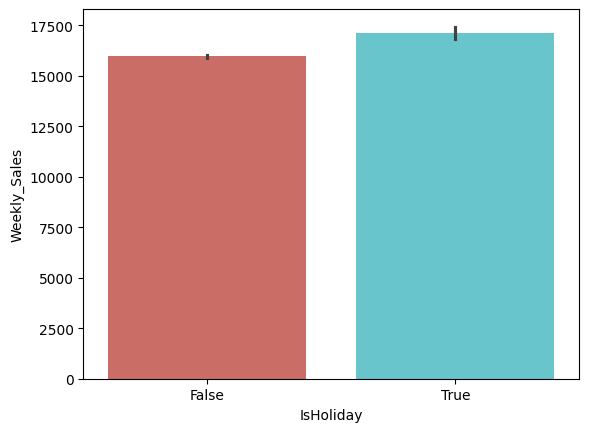

In [24]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df, palette='hls')

In [25]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [26]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique()

133

В данных присутствуют не все праздничные дни. Существует 4 значимых праздника, которых здесь нет;
* Суперкубок: 12 февраля 2010, 11 февраля 2011, 10 февраля 2012, 8 февраля 2013
* День труда: 10 сентября 2010, 9 сентября 2011, 7 сентября 2012, 6 сентября 2013
* День благодарения: 26 ноября 2010, 25 ноября 2011, 23 ноября 2012, 29 ноября 2013
* Рождество: 31 декабря 2010, 30 декабря 2011, 28 декабря 2012, 27 декабря 2013

Период праздников 7 сентября 2012 находится в тестовых данных. Если посмотреть на данные, то средние недельные продажи в праздничные дни значительно выше, чем в нерабочие дни. В тренировочных данных указано, что 133 недели не являются выходными, а 10 недель - являются.

Хочется подмечать подобные различия между типами праздников. Поэтому создадим новые столбцы для 4-х типов праздников и заполним их следующими значениями: если эта дата праздник, то True, и False иначе.

In [27]:
# День проведения Суперкубка
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [28]:
# День труда
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [29]:
# День благодарения
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [30]:
# Рождество
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

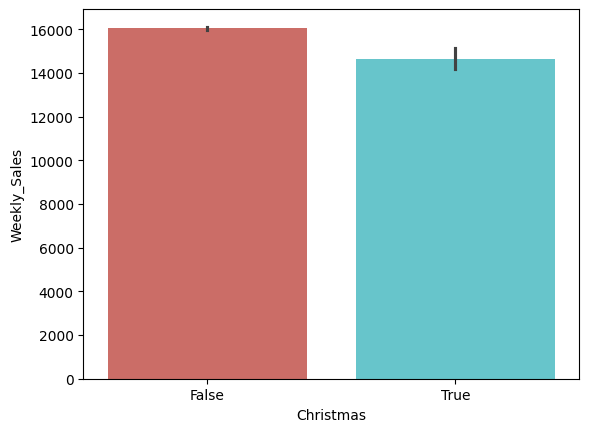

In [31]:
# Рождество / другой день
sns.barplot(x='Christmas', y='Weekly_Sales', data=df, palette='hls')

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

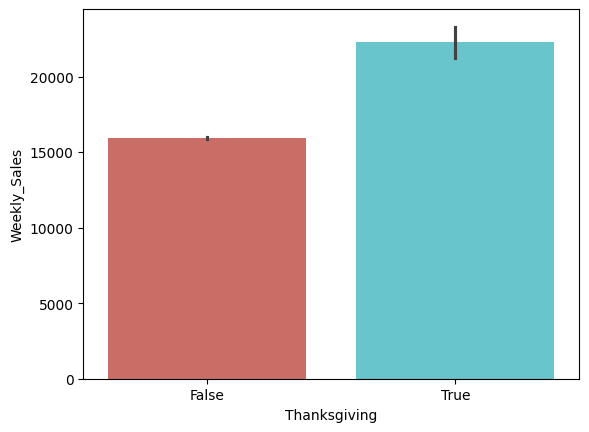

In [32]:
# День благодарения / другой день
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df, palette='hls')

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

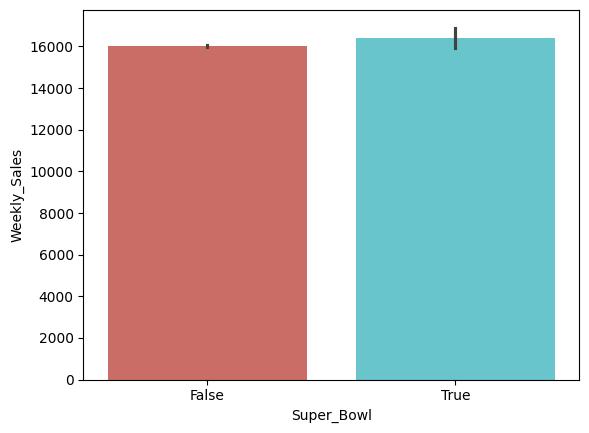

In [33]:
# День проведения Суперкубка / другой день
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df, palette='hls')

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

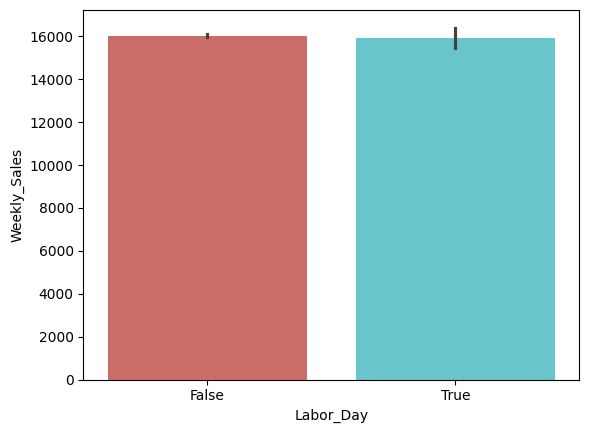

In [34]:
# День труда / другой день
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df, palette='hls')

На графиках видно, что День труда и Рождество не сильно увеличивают средние недельные продажи. Суперкубок положительно влияет на продажи, но наибольшая разница наблюдается в День благодарения. Стоит предположить, что люди обычно предпочитают покупать рождественские подарки за 1-2 недели до Рождества, так что это не влияет на продажи на рождественской неделе. А на неделе благодарения проводятся распродажи в Черную пятницу.

**Влияние типа магазина на праздничные дни**

Есть три типа магазинов: A, B и C.

In [35]:
# Средние продажи в соответствии с Рождеством
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [36]:
# Средние продажи в соответствии с Днем труда
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [37]:
# Средние продажи в соответствии с Днем благодарения
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [38]:
# Средние продажи в соответствии с Суперкубком
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

Посмотрим на процентное соотношение типов магазинов.

In [39]:
df['Type'].value_counts(normalize=True) * 100

,proportion
Type,
A,51.155369
B,38.739255
C,10.105375


In [40]:
t_labels = ['A', 'B', 'C']

fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])
fig.add_trace(go.Pie(labels=t_labels, values=df['Type'].value_counts(),
                     name="Тип"), 1, 1)

fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)
my_labels = 'Тип A', 'Тип B', 'Тип C'
fig.update_layout(
    title_text="Распределение по типу магазина",
    annotations=[dict(text='Тип', font_size=20, showarrow=False)])
fig.show()

In [41]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

,Weekly_Sales
IsHoliday,
False,15952.816352
True,17094.300918


Около половины магазинов относится к типу "A".

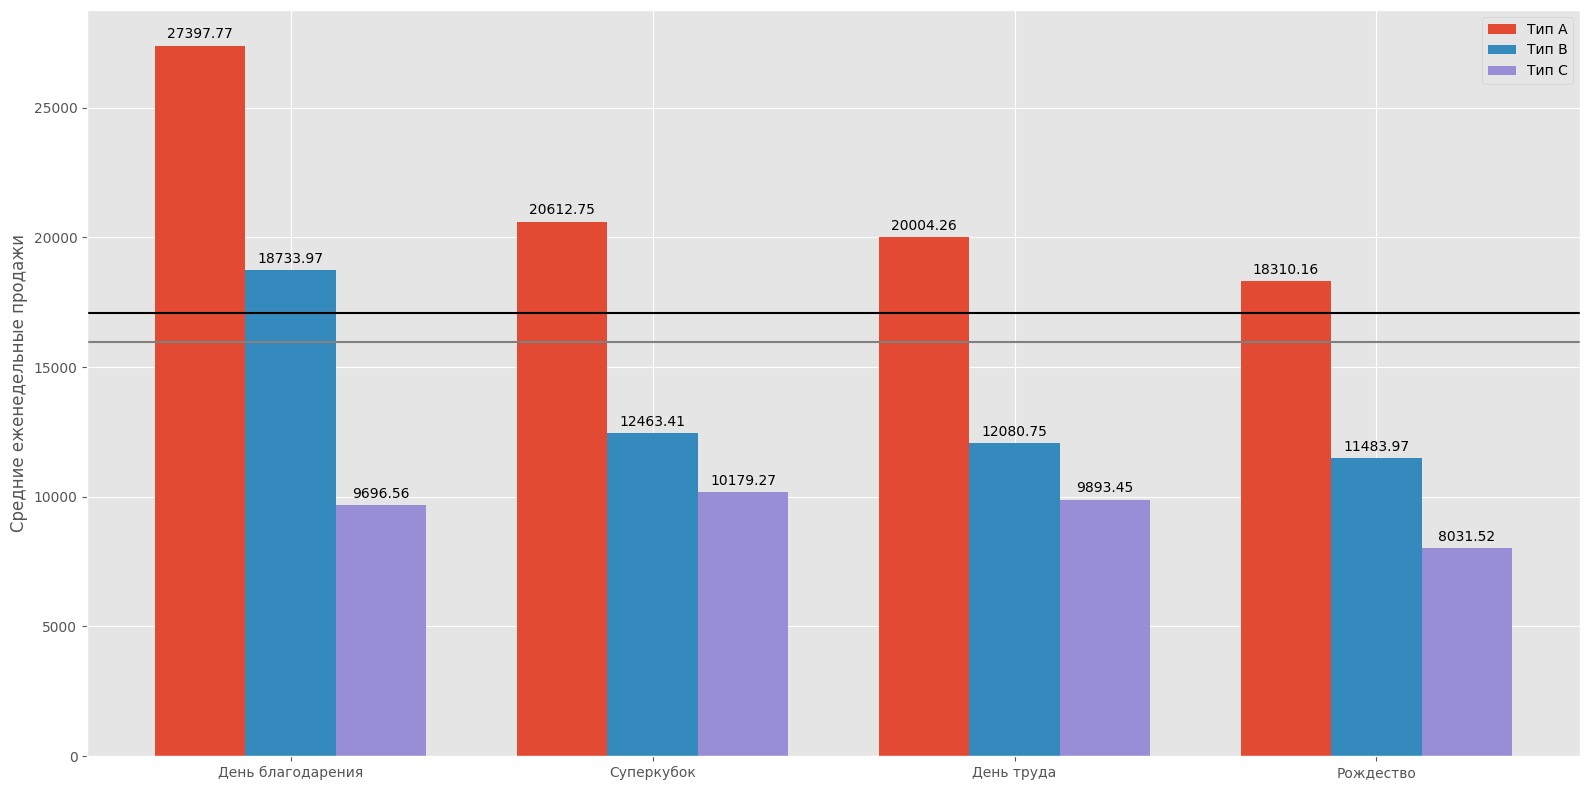

In [42]:
# График средних еженедельных продаж в зависимости от праздника и типа магазина
plt.style.use('ggplot')
labels = ['День благодарения', 'Суперкубок', 'День труда', 'Рождество']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Тип A')
rects2 = ax.bar(x , B_means, width, label='Тип B')
rects3 = ax.bar(x + width, C_means, width, label='Тип C')

ax.set_ylabel('Средние еженедельные продажи')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='black')  # праздничные средние продажи
plt.axhline(y=15952.82,color='grey')  # непраздничные средние продажи

fig.tight_layout()

plt.show()

Из графика видно, что самые высокие средние продажи приходятся на неделю благодарения между праздниками. И, во все праздничные дни, в магазинах типа А самые высокие продажи.

In [43]:
df.sort_values(by='Weekly_Sales', ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
95373,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
338013,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
95425,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
337961,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
135665,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


Кроме того, неудивительно, что топ-5 самых высоких еженедельных продаж приходится на недели благодарения.

**Соотношение типов и размеров**

In [44]:
df_store.groupby('Type').describe()['Size'].round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


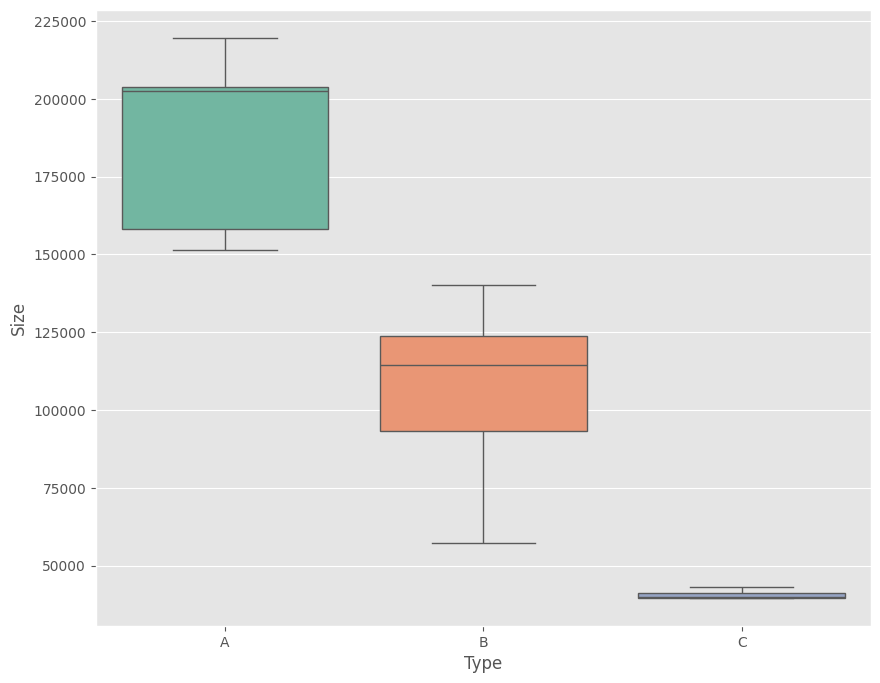

In [45]:
plt.figure(figsize=(10,8))
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False, palette='Set2')

Размер типа магазина соответствует объему продаж, как и ожидалось. Кроме того, Walmart классифицирует магазины в соответствии с их размерами в соответствии с графиком. После наименьшего значения размера для типа A начинается тип B. После наименьшего значения размера типа B начинается тип C.

**Столбцы уценки**

Walmart предоставил столбцы с уценкой, чтобы увидеть, как уценка влияет на продажи. При проверки столбцов можно заметить, что для уценки используется множество значений NaN. Их можно заменить на 0, потому что, если в строке есть уценка, она отображается цифрами. Итак, в графе уценки указано 0, это значит, что на эту дату уценок нет.

In [46]:
df.isna().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,270031
MarkDown2,309308
MarkDown3,283561


In [47]:
df = df.fillna(0)

In [48]:
df.isna().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,0
MarkDown2,0
MarkDown3,0


In [49]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


Минимальное значение для еженедельных продаж - 0,01. Скорее всего, это значение неверно, но предпочтем не менять его сейчас. Потому что здесь много отделов и магазинов. Проверка каждого отдела для каждого магазина занимает слишком много времени (45 магазинов на 81 отдел). Итак, будем ориентироваться на средние значения для EDA.

**Более глубой взгляд на продажи**

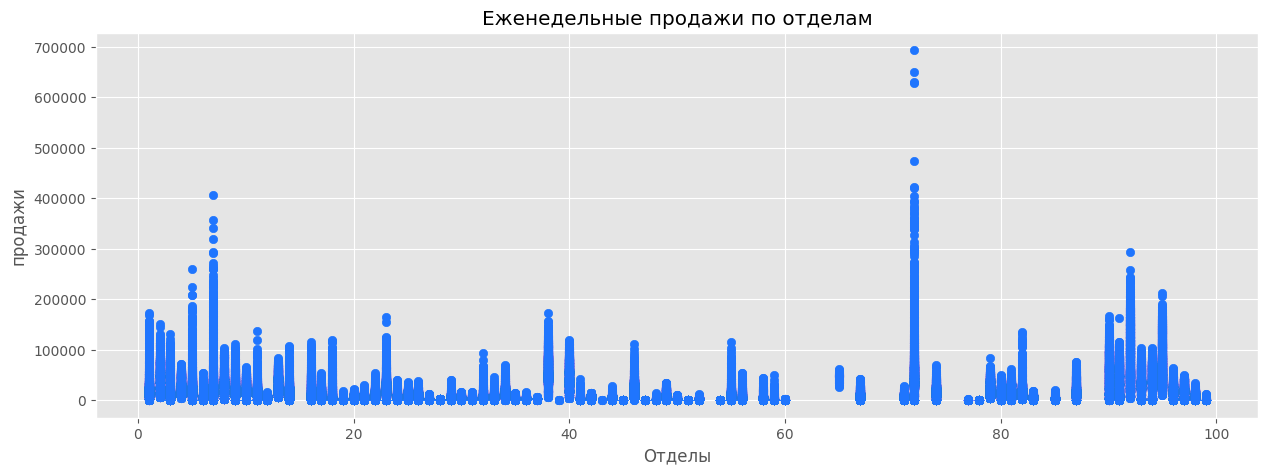

In [50]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Еженедельные продажи по отделам')
plt.xlabel('Отделы')
plt.ylabel('продажи')
plt.scatter(x, y, c='#1f75fe')
plt.show()

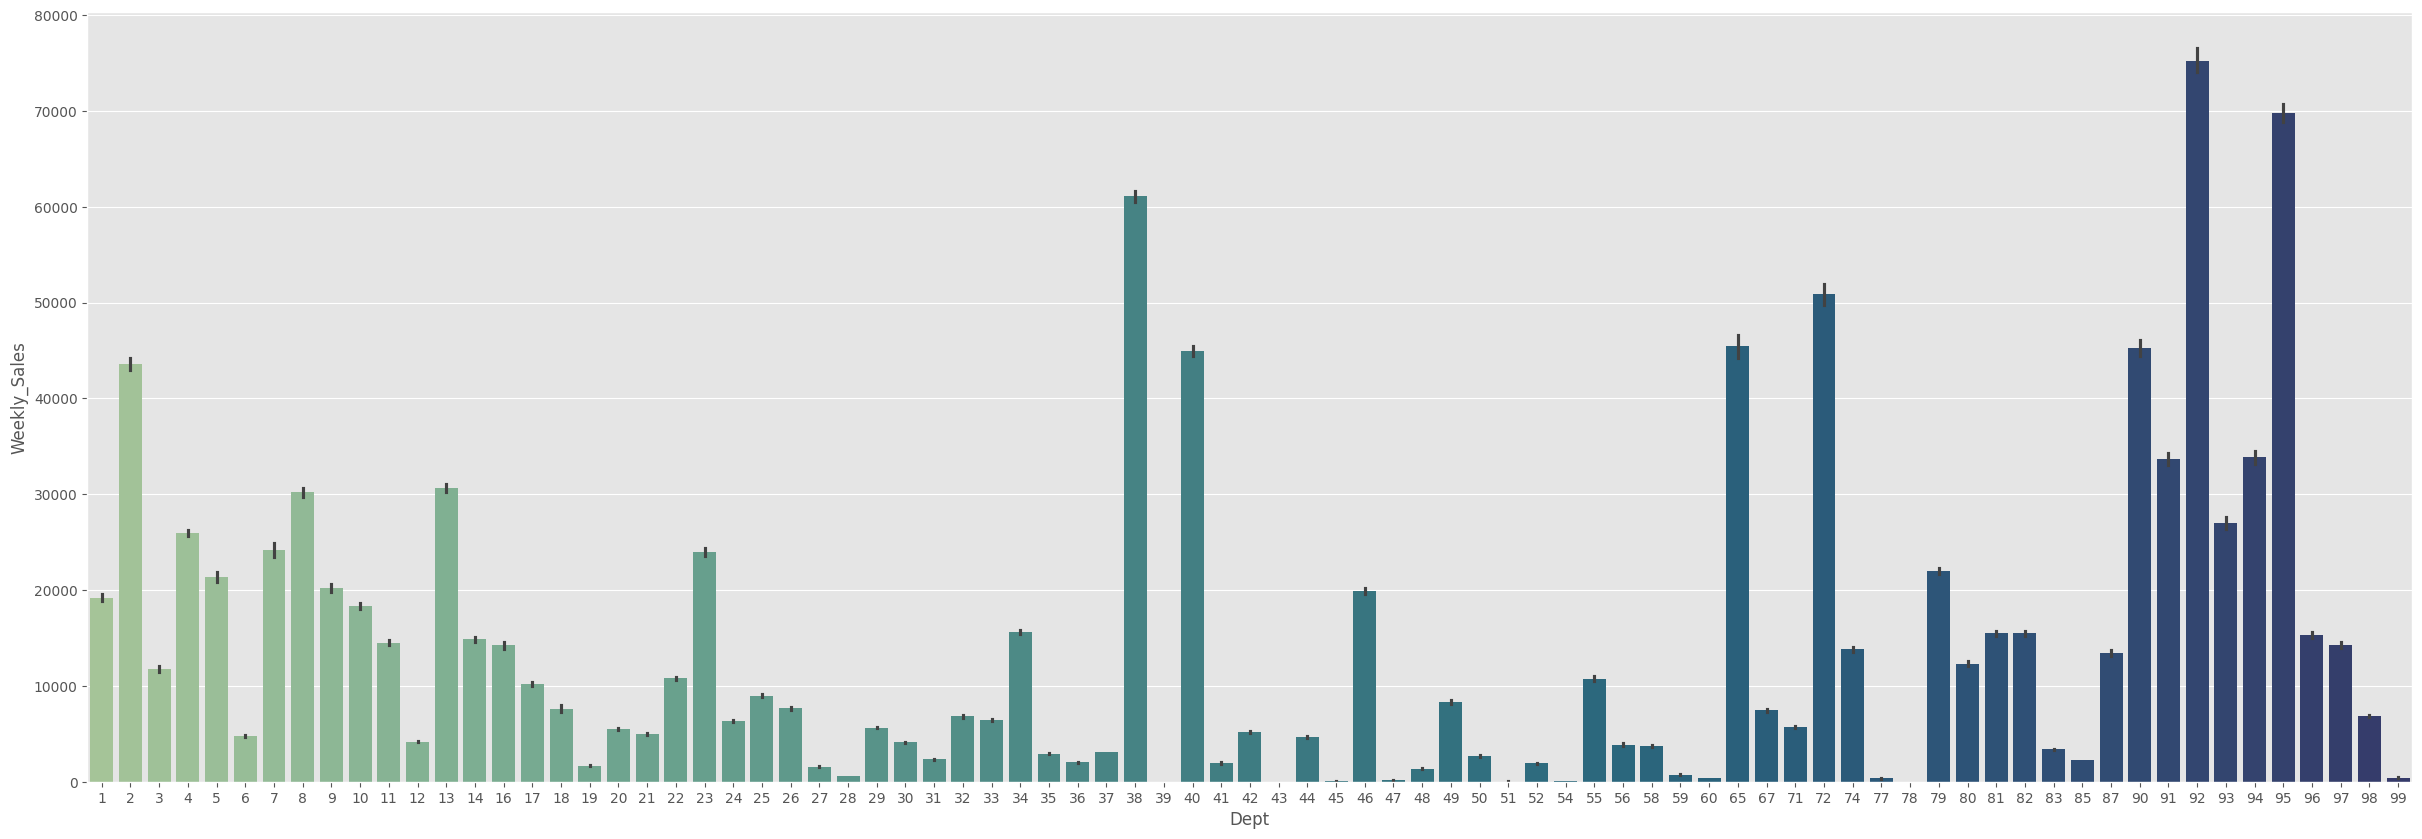

In [51]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df, palette='crest')

Из первого графика видно, что у одного отдела в диапазоне от 60 до 80 (предположительно, 72) показатели продаж выше. Но, когда мы берем средние значения, видно, что у отдела 92 средние показатели продаж выше. Отдел 72, скорее всего, сезонный. В некоторые сезоны он имеет более высокие значения, но в среднем 92 выше.

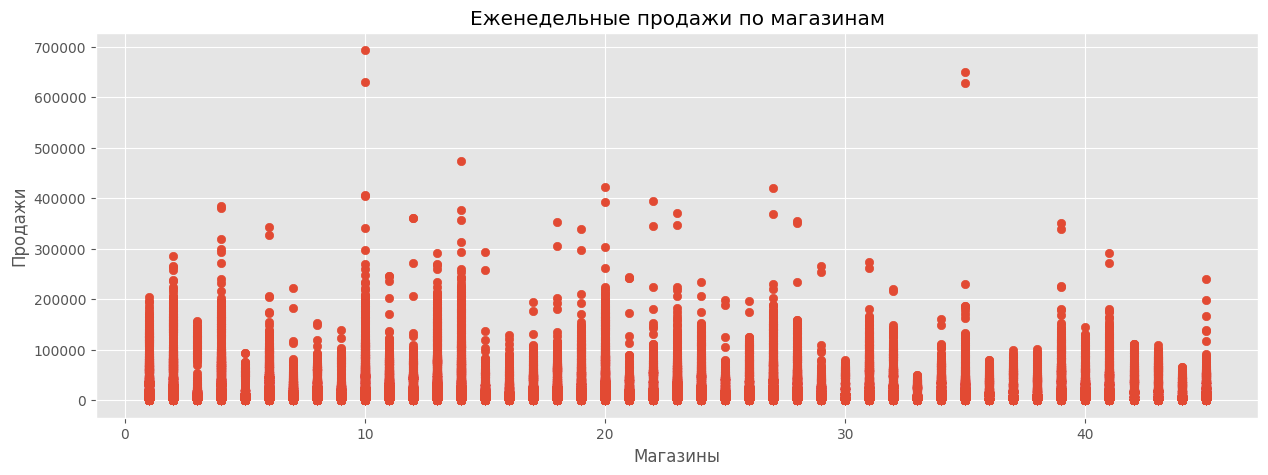

In [52]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Еженедельные продажи по магазинам')
plt.xlabel('Магазины')
plt.ylabel('Продажи')
plt.scatter(x,y)
plt.show()

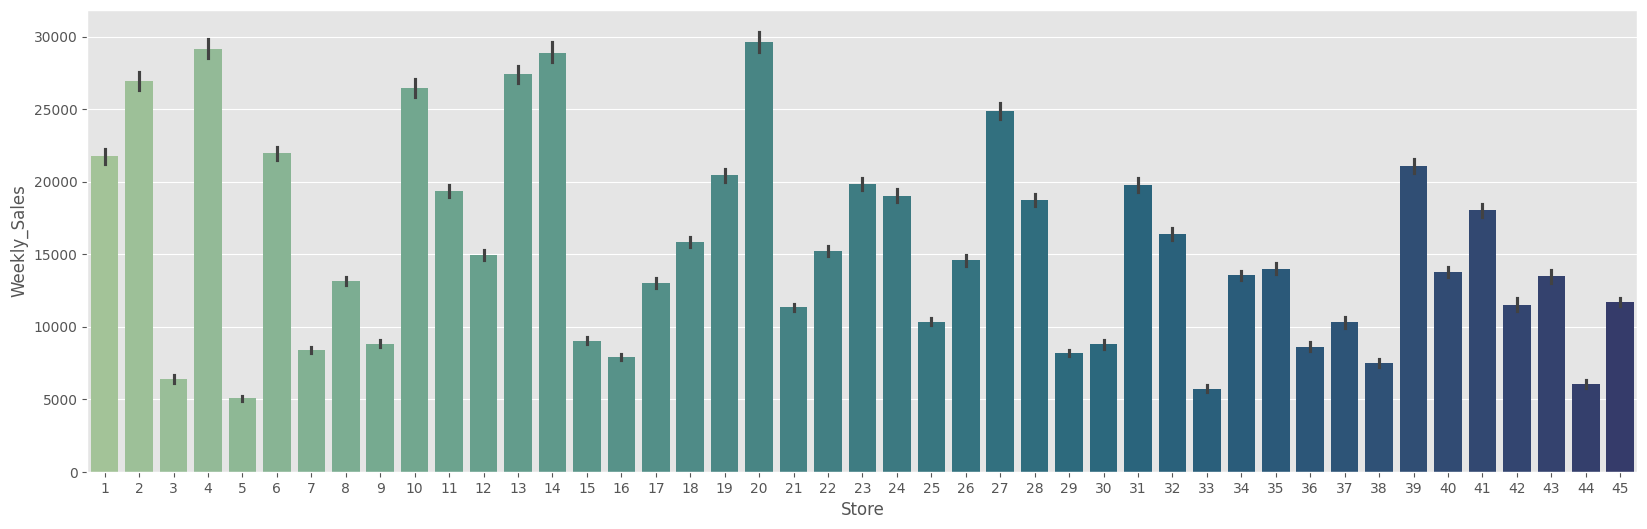

In [53]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df, palette='crest')

То же самое происходит и в магазинах. На первом графике видно, что в некоторых магазинах продажи выше, но в среднем 20-й магазин является лучшим, а за ним следуют 4-й и 14-й.

**Изменение даты на Datetime и создание новых столбцов**

In [54]:
df["Date"] = pd.to_datetime(df["Date"])
df['week'] = df['Date'].dt.isocalendar().week
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

In [55]:
df.groupby('month')['Weekly_Sales'].mean()

,Weekly_Sales
month,
1,14182.239153
2,16048.701191
3,15464.817698
4,15696.435193
5,15845.556200
6,16397.605478
7,15905.472425
8,16113.800069
9,15147.216063


In [56]:
df.groupby('year')['Weekly_Sales'].mean()

,Weekly_Sales
year,
2010,16318.648285
2011,16007.797985
2012,15748.265005


<Axes: xlabel='month'>

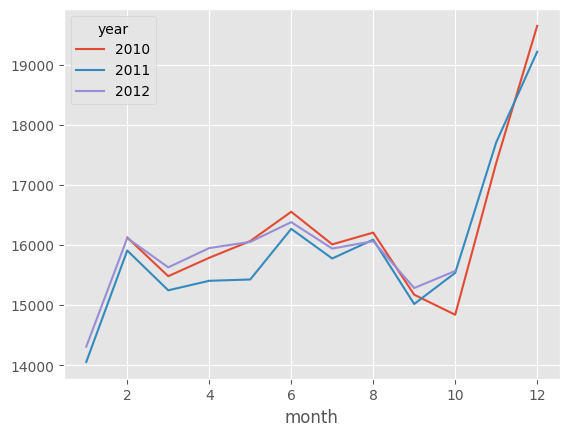

In [57]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales",
                               columns = "year", index = "month")
monthly_sales.plot()

Из графика видно, что в 2011 году продажи были ниже, чем в 2010 году в целом. Если мы посмотрим на средние показатели продаж, то увидим, что в 2010 году они были выше, но в 2012 году нет информации о ноябре и декабре, в которых продажи были выше. Несмотря на то, что в 2012 году за последние два месяца не было продаж, это означает, что он близок к 2010 году. Скорее всего, он займет первое место, если мы получим результаты за 2012 год и добавим их.

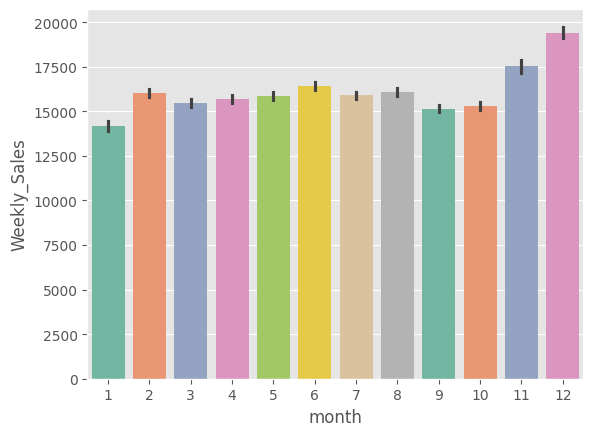

In [58]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df, palette='Set2')

Если мы посмотрим на график выше, то увидим, что, как и ожидалось, лучшие продажи приходятся на декабрь и ноябрь. Самые высокие показатели приходятся на День благодарения, но если взять среднее значение, то становится очевидным, что наилучшие показатели в декабре

In [59]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

,Weekly_Sales
week,
51,26454.164116
47,22269.601768
50,20478.421134
49,18731.794840
22,16856.650245


Топ-5 средних еженедельных продаж приходится на 1-2 недели перед Рождеством, Днем благодарения, Черную пятницу и конец мая, когда школы закрыты.

<Axes: xlabel='week'>

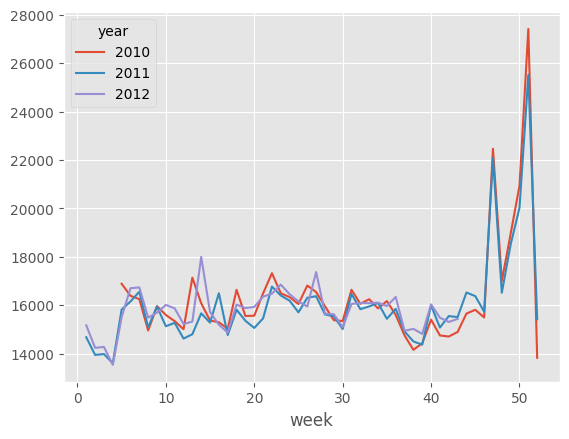

In [60]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

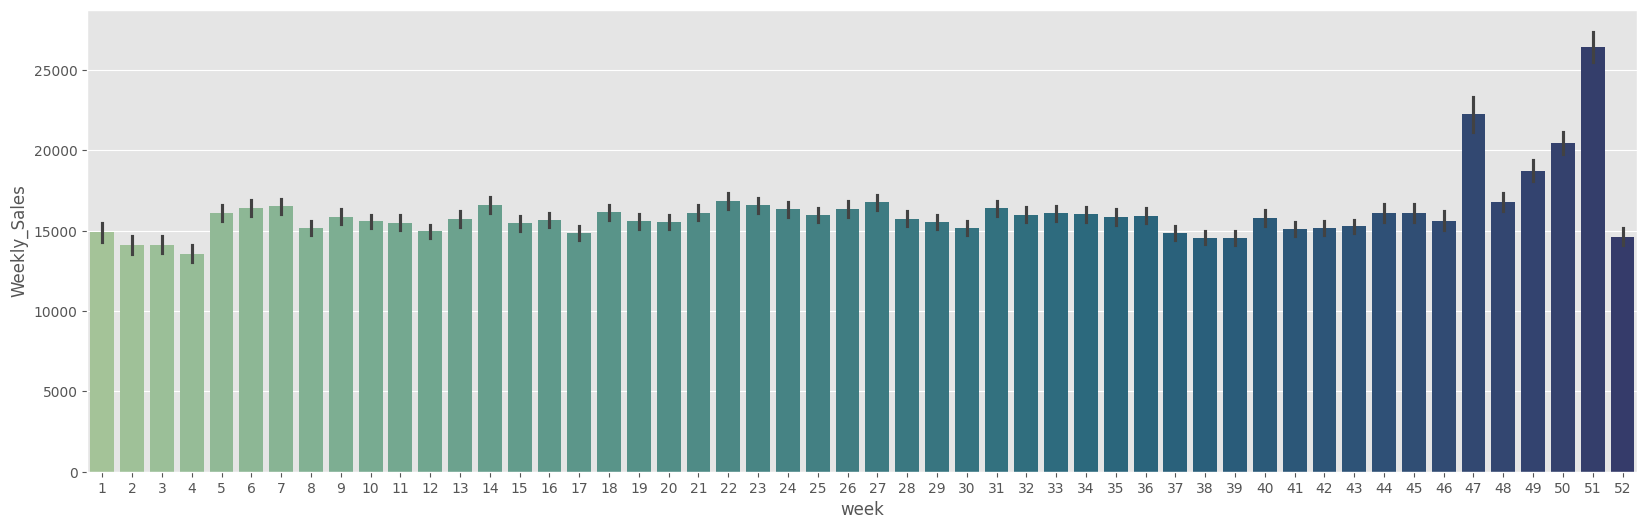

In [61]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df, palette='crest')

Из графиков видно, что средние показатели на 51-й и 47-й неделях значительно выше из-за эффектов Рождества, Дня благодарения и Черной пятницы.

**Цены на топливо, индекс потребительских цен , безработица, влияние температуры**

<Axes: xlabel='Fuel_Price'>

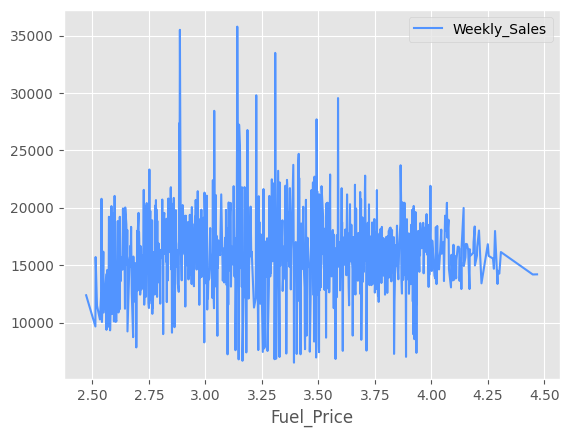

In [62]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot(c='#5294ff')

<Axes: xlabel='Temperature'>

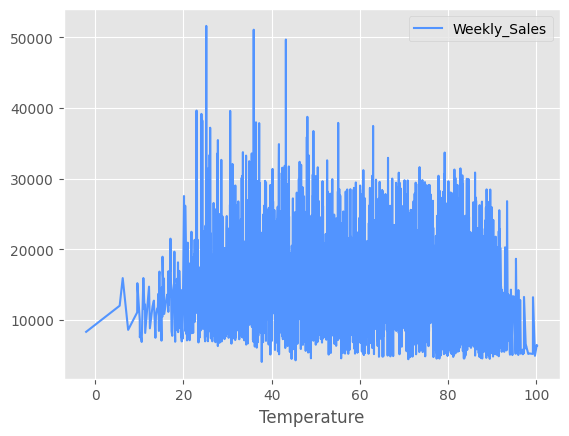

In [63]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot(c='#5294ff')

<Axes: xlabel='CPI'>

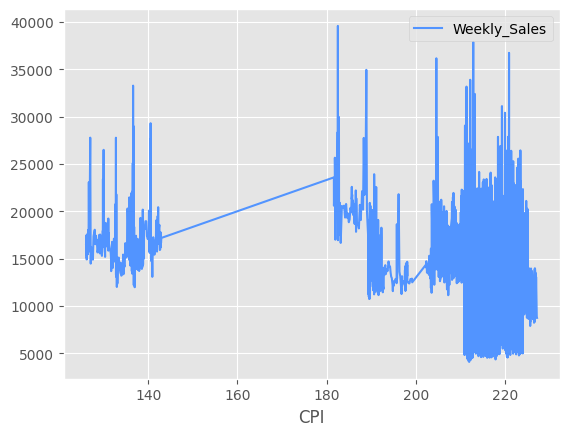

In [64]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot(c='#5294ff')

<Axes: xlabel='Unemployment'>

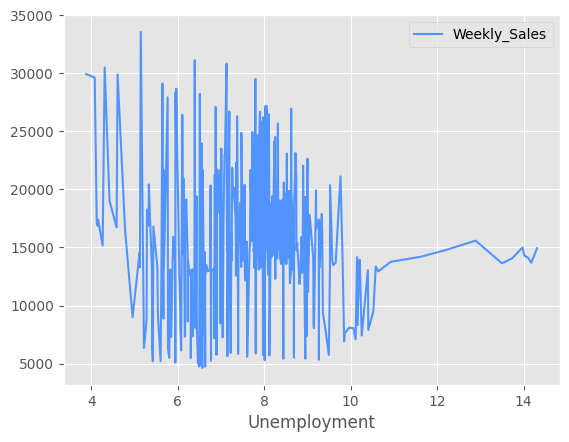

In [65]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot(c='#5294ff')

Из графиков видно, что между индексом потребительских цен, температурой, уровнем безработицы, ценами на топливо и еженедельными продажами нет существенных закономерностей. Также нет данных по индексу потребительских цен в диапазоне 140-180.

In [66]:
df.to_csv('clean_data.csv')  # создаем новый датафрейм, чтобы использовать позже

**Очистка данных**

* В данных не слишком много пропущенных значений. Все столбцы были проверены;
* Были выбраны строки, в которых еженедельные продажи превышают 0. Минус-значения составляют 0,3% от данных. Поэтому они были удалены;
* Значения Null в уценках изменились на ноль. Потому что они записывались как Null, если в этом отделе не было уценки.

**Исследование и некоторые выводы по данным**

* В базе данных 45 магазинов и 81 отдел. Отделы не во всех магазинах одинаковые;
* Хотя еженедельные показатели продаж в отделе 72 выше, в среднем лучше всего в отделе 92. Это показывает, что в некоторых отделах показатели выше из-за сезонности, например, в День Благодарения. Когда мы смотрим на данные о 5 крупнейших продажах, становится очевидным, что все они относятся к 72-му отделу во время празднования Дня благодарения;
* Хотя магазины 10 и 35 иногда демонстрируют более высокие показатели недельных продаж, в целом в среднем магазины 20 и 4 находятся на первом и втором местах. Это означает, что в некоторых регионах сезонные продажи выше;
* Магазины делятся на 3 типа: A, B и C в зависимости от их размеров. Почти половина магазинов, количество которых превышает 150 000, относятся к категории A. В зависимости от типа, продажи в магазинах меняются;
* Как и ожидалось, средние продажи в праздничные дни выше, чем в обычные дни;
* Рождественские праздники считаются последними днями в году. Но люди обычно совершают покупки на 51-й неделе. Итак, если посмотреть на общий объем продаж в праздничные дни, то у Дня благодарения самый высокий показатель продаж между ними;
* В 2010 году продажи были выше, чем в 2011 и 2012 годах. Но данные о продажах за ноябрь и декабрь за 2012 год не указаны. Даже без учета месяцев наибольших продаж, 2012 год ненамного уступает 2010 году, поэтому после добавления последних двух месяцев он может стать первым;
* Очевидно, что 51-я и 47-я недели имеют более высокие значения, а за ними следуют 50-48-я недели. Интересно, что 5-е место по продажам приходится на 22-ю неделю года. Эти результаты показывают, что Рождество, День благодарения и Черная пятница являются наиболее важными для распродаж, чем другие недели, и 5-е по важности время - это 22-я неделя года и конец мая, когда школы закрыты. Скорее всего, люди готовятся к праздникам в конце мая;
* Продажи в январе значительно ниже, чем в другие месяцы. Это результат высоких продаж в ноябре и декабре. После двух месяцев высоких продаж люди предпочитают платить меньше в январе;
* Индекс потребительских цен, температура, уровень безработицы и цены на топливо никак не влияют на еженедельные продажи.

##Перебор моделей и выявление лучшего решения

**Пробная попытка с Random Forest**

Как правило, регрессор Rondom Forest дает хорошие результаты, если мы его хорошо настроим. Итак, чтобы найти простую базовую модель, будем использовать RandomForestRegressor.

Нашей метрикой для этого проекта является средневзвешенная абсолютная ошибка (WMAE).

$$\text{WMAE}=\frac1{\sum w_i} \sum^n_{i=1} w_i|y_i-\hat y_i|$$

где

* n - число строк;
* $\hat y_i$ - предсказанные продажи;
* $y_i$ - реальные продажи;
* $w_i$ веса ($w = 5$, если неделя является праздничной и $1$ иначе).

С учетом этого показателя цена ошибки в праздничные недели в 5 раз больше, чем в обычные недели. Поэтому более важно точно прогнозировать продажи в праздничные недели. Все результаты можно найти в конце этого ноутбука.

In [67]:
df = pd.read_csv('./clean_data.csv')

In [68]:
df.drop(columns=['Unnamed: 0'],inplace=True)

**Энкодинг данных**

Для предварительной обработки наших данных изменим логические значения holidays на 0-1 и заменим типы хранилищ с A, B, C на 1, 2, 3.

In [69]:
df_encoded = df.copy()

In [70]:
type_group = {'A':1, 'B': 2, 'C': 3}
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [71]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(int)

In [72]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(int)

In [73]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(int)

In [74]:
df_encoded['Christmas'] = df_encoded['Christmas'].astype(int)

In [75]:
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(int)

In [76]:
df_new = df_encoded.copy()

**Взаимосвязь фичей**

Во-первых, удалим разделенные праздничные столбцы из данных и попробуем обойтись без них. Чтобы сохранить закодированные данные в безопасности, мы сделали новый датафрейм, который и будет использоваться.

In [77]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True)

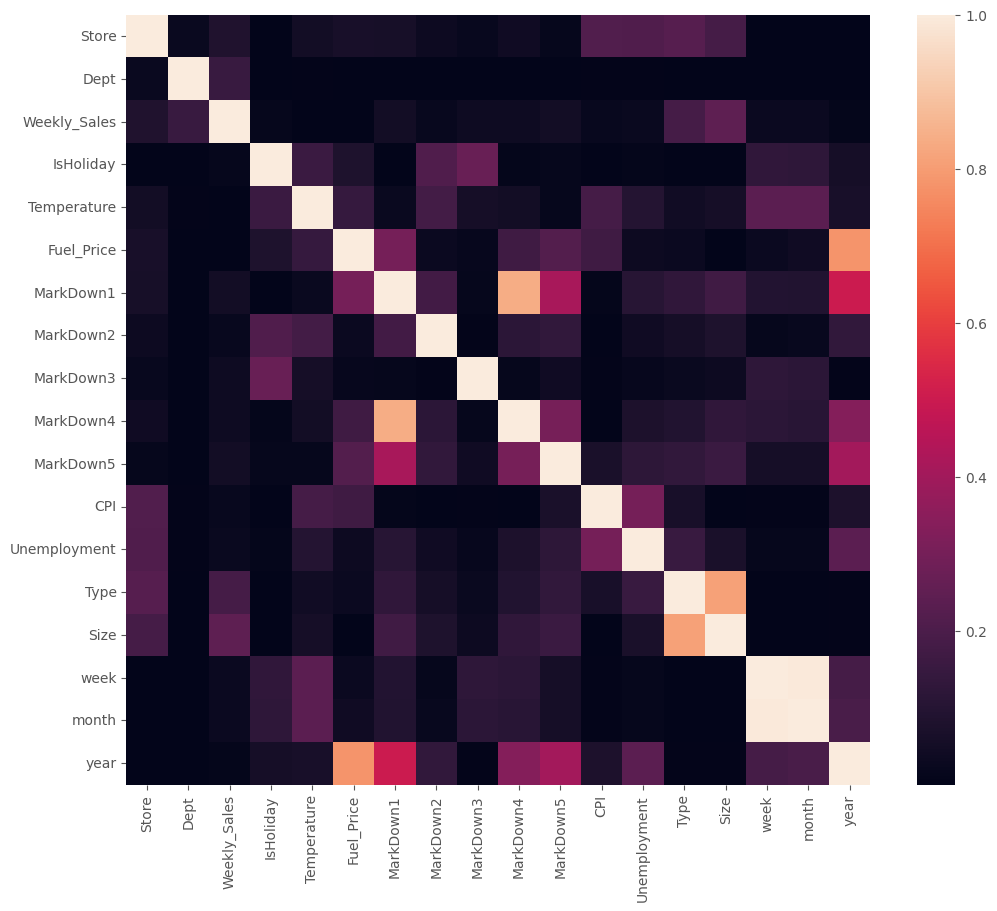

In [78]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.drop(['Date'], axis=1).corr().abs())
plt.show()

Температура, безработица, индекс потребительских цен не оказывают существенного влияния на еженедельные продажи, поэтому исключим их. Кроме того, уценка 4 и 5 сильно коррелируют с уценкой 1. Поэтому также исключим их. Возможно, это может создать проблему мультиколлинеарности. Итак, сначала попробуем обойтись без них.

In [79]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True)

In [80]:
df_new['Date'] = pd.to_datetime(df_new['Date'], format='%Y-%m-%d')

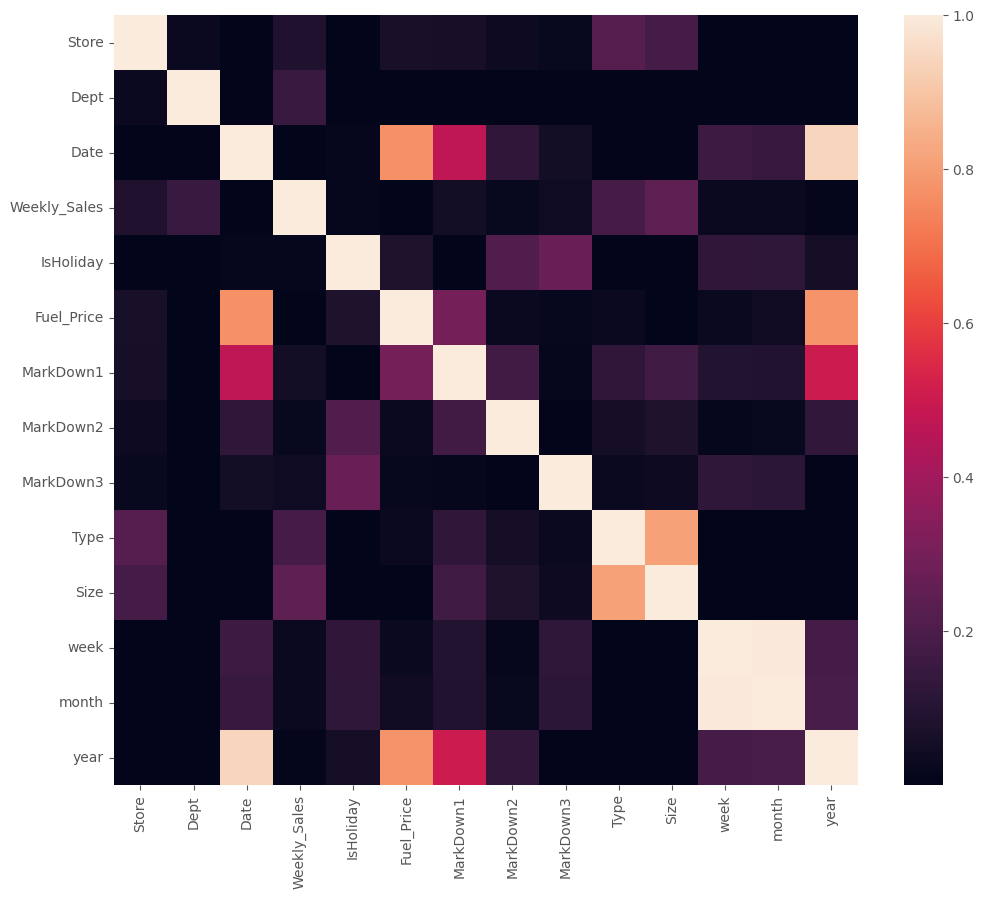

In [81]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())
plt.show()

Размер и тип магазина сильно коррелируют с еженедельными продажами. Кроме того, отдел и магазин коррелируют с продажами.

In [82]:
df_new = df_new.sort_values(by='Date', ascending=True)

**Разделение на тренировочную/тестовую выборки**

В нашем столбце даты указаны непрерывные значения, поэтому, чтобы сохранить функции даты, не будем использовать случайное разделение. поэтому разделим данные вручную в соответствии с 70%.

In [83]:
train_data = df_new[:int(0.7*(len(df_new)))]
test_data = df_new[int(0.7*(len(df_new))):]

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]]

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [84]:
X = df_new[used_cols]

У нас имеется достаточно информации о дате, такой как неделя в году. Поэтому удалим столбец Date.

In [85]:
X_train = X_train.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

**Функция WMAE**

In [86]:
def wmae_test(test, pred):  # WMAE
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

**Random Forest Regressor**

Чтобы настроить регрессор, можно использовать gridsearch, но для этого датасета, содержащих много строк и столбцов, требуется слишком много времени. Поэтому выбираем параметры регрессора вручную. Каждый раз меняем параметры и пытаемся найти наилучший результат.

In [87]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

pipe = make_pipeline(scaler, rf)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_train)

y_pred_test = pipe.predict(X_test)

In [88]:
wmae_test(y_test, y_pred_test)

5560.985577513869

Для первой попытки имеем взвешенную ошибку в районе 5700.

**Посмотрим на важность фичей**

In [89]:
X = X.drop(['Date'], axis=1)

Ранжирование по важности:
1. feature 1 (0.730268)
2. feature 8 (0.113044)
3. feature 0 (0.059433)
4. feature 7 (0.033012)
5. feature 9 (0.022478)
6. feature 3 (0.018158)
7. feature 10 (0.008422)
8. feature 6 (0.005359)
9. feature 4 (0.003098)
10. feature 2 (0.002581)
11. feature 5 (0.002467)
12. feature 11 (0.001680)


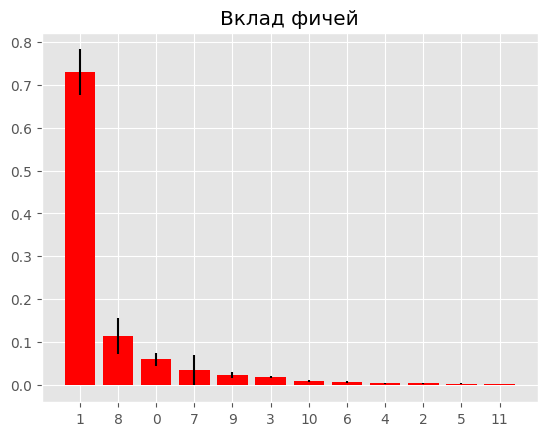

In [90]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Ранжирование по важности:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure()
plt.title("Вклад фичей")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Оценив важность фичей, отбросим 3-4 наименее важных фичи и попробуем модель. Лучший результат был получен, когда отбросили столбец "month", который сильно коррелирует с "week".

In [91]:
X1_train = X_train.drop(['month', X_train.columns[2], X_train.columns[4], X_train.columns[5], X_train.columns[11]], axis=1)
X1_test = X_test.drop(['month', X_train.columns[2], X_train.columns[4], X_train.columns[5], X_train.columns[11]], axis=1)

In [92]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

y_pred = pipe.predict(X1_train)

y_pred_test = pipe.predict(X1_test)

In [93]:
wmae_test(y_test, y_pred_test)

4119.66775536841

Это дает лучшие результаты, чем первоначальные.

**Модель, использующая все данные**

Теперь хочется понять, учится ли модель на удаленных столбцах или нет. Итак, снова применим модель ко всем закодированным данным.

In [94]:
df_encoded['Date'] = pd.to_datetime(df_encoded['Date'], format='%Y-%m-%d')

In [95]:
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]]

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [96]:
X_enc = df_encoded[used_cols1]

In [97]:
X_enc = X_enc.drop(['Date'], axis=1)

In [98]:
X_train_enc = X_train_enc.drop(['Date'], axis=1)
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [99]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt', min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

y_pred_enc = pipe.predict(X_train_enc)

y_pred_test_enc = pipe.predict(X_test_enc)

In [100]:
wmae_test(y_test_enc, y_pred_test_enc)

2575.0524460162424

Мы получили более хорошие результаты при обучении модели на всём объеме данных, следовательно, удаленные ранее столбцы были важны.

**Важность фичей для полного датасета**

Ранжирование по важности:
1. feature 1 (0.744936)
2. feature 13 (0.072992)
3. feature 12 (0.042149)
4. feature 0 (0.031195)
5. feature 10 (0.030127)
6. feature 11 (0.017593)
7. feature 18 (0.012205)
8. feature 3 (0.011344)
9. feature 4 (0.010062)
10. feature 19 (0.005350)
11. feature 7 (0.004655)
12. feature 9 (0.003688)
13. feature 5 (0.003473)
14. feature 8 (0.003320)
15. feature 6 (0.002483)
16. feature 16 (0.001193)
17. feature 20 (0.001147)
18. feature 2 (0.000941)
19. feature 17 (0.000579)
20. feature 15 (0.000286)
21. feature 14 (0.000281)


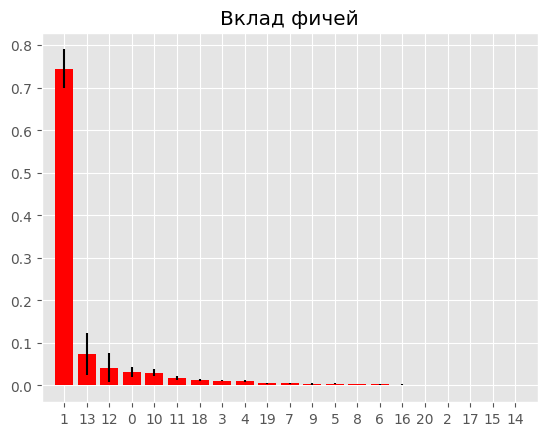

In [101]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Ранжирование по важности:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure()
plt.title("Вклад фичей")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

В соответствии с важностью фичей удалим несколько столбцов из всего набора и попробуем модель еще раз.

In [102]:
drop_col = [X_train_enc.columns[14], X_train_enc.columns[15], X_train_enc.columns[17],
            X_train_enc.columns[2], X_train_enc.columns[16], X_train_enc.columns[20],
            X_train_enc.columns[6], X_train_enc.columns[5], X_train_enc.columns[8],
            X_train_enc.columns[9], X_train_enc.columns[7],
            X_train_enc.columns[4], X_train_enc.columns[3], X_train_enc.columns[18],
            X_train_enc.columns[11], X_train_enc.columns[10]]

In [103]:
df_encoded_new = df_encoded.copy()
df_encoded_new.drop(drop_col, axis=1, inplace=True)

In [104]:
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]]

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [105]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()

pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

y_pred_enc = pipe.predict(X_train_enc1)

y_pred_test_enc = pipe.predict(X_test_enc1)

In [106]:
pipe.score(X_test_enc1,y_test_enc1)

0.751698495604959

In [107]:
wmae_test(y_test_enc1, y_pred_test_enc)

1695.6429815364763

Как мы видим, результаты стали ещё лучше!

**Модель без учета столбца месяца**

In [108]:
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

In [109]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

In [110]:
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

In [111]:
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]]

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

In [112]:
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

y_pred_enc = pipe.predict(X_train_enc2)

y_pred_test_enc = pipe.predict(X_test_enc2)

In [113]:
pipe.score(X_test_enc2,y_test_enc2)

0.7223764624431692

In [114]:
wmae_test(y_test_enc2, y_pred_test_enc)

1585.134978526541

Можно заметить, что без этого столбца качество работы модели повышается.

In [115]:
df_results = pd.DataFrame(columns=["Model", "Info", 'WMAE'])

In [116]:
df_results = pd.concat([df_results, pd.DataFrame({"Model": ['RandomForestRegressor'],
                                                  "Info": ['Без разделенных столбцов праздников'],
                                                  'WMAE': [5698]})], ignore_index=True)

In [117]:
df_results = pd.concat([df_results, pd.DataFrame({"Model": ['RandomForestRegressor'],
                                                  "Info": ['Без разделенных столбцов праздников + селекция признаков'],
                                                  'WMAE': [4232]})], ignore_index=True)

In [118]:
df_results = pd.concat([df_results, pd.DataFrame({"Model": ['RandomForestRegressor'],
                                                  "Info": ['На всех данных'],
                                                  'WMAE': [2684]})], ignore_index=True)

In [119]:
df_results = pd.concat([df_results, pd.DataFrame({"Model": ['RandomForestRegressor'],
                                                  "Info": ['На всех данных + селекция признаков'],
                                                  'WMAE': [1715]})], ignore_index=True)

In [120]:
df_results = pd.concat([df_results, pd.DataFrame({"Model": ['RandomForestRegressor'],
                                                  "Info": ['На всех данных + без месяца'],
                                                  'WMAE': [1583]})], ignore_index=True)

In [121]:
df_results

,Model,Info,WMAE
0,RandomForestRegressor,Без разделенных столбцов праздников,5698
1,RandomForestRegressor,Без разделенных столбцов праздников + селекция...,4232
2,RandomForestRegressor,На всех данных,2684
3,RandomForestRegressor,На всех данных + селекция признаков,1715
4,RandomForestRegressor,На всех данных + без месяца,1583


Наилучшие результаты получаются при использовании всего набора данных с выбором признаков без учета месяца. Теперь попробуем использовать модели временных рядов.

**Модели временных рядов**

In [122]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,8.106,A,151315,True,False,False,False,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,9,3,2010


In [123]:
df["Date"] = pd.to_datetime(df["Date"])

In [124]:
df.set_index('Date', inplace=True)

**График продаж**

<Axes: xlabel='Date', ylabel='Weekly_Sales'>

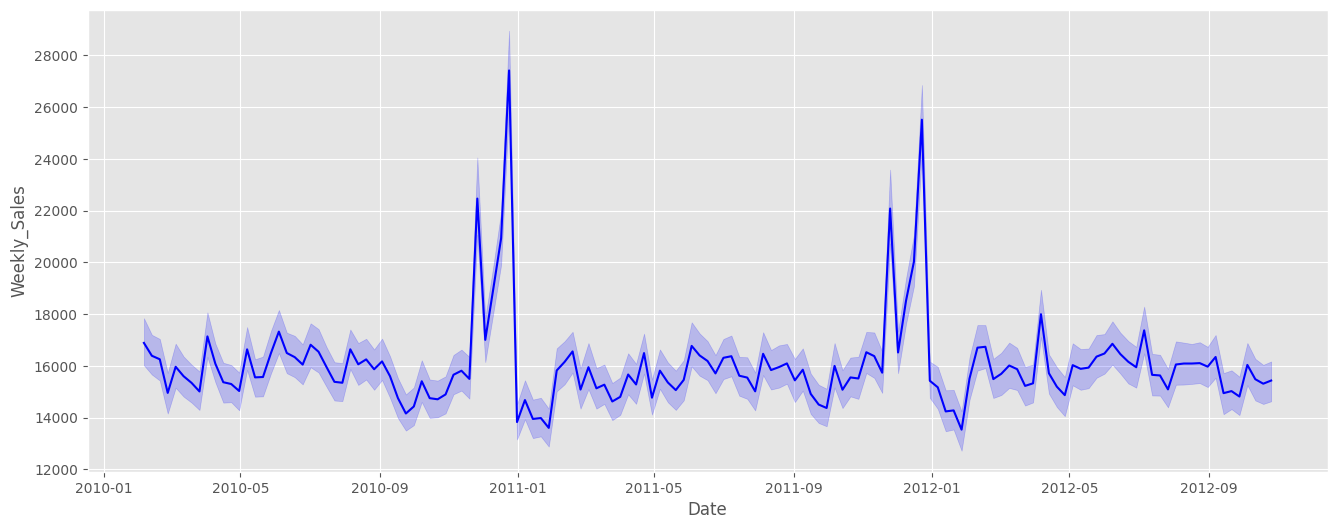

In [125]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df['Weekly_Sales'], c='b')

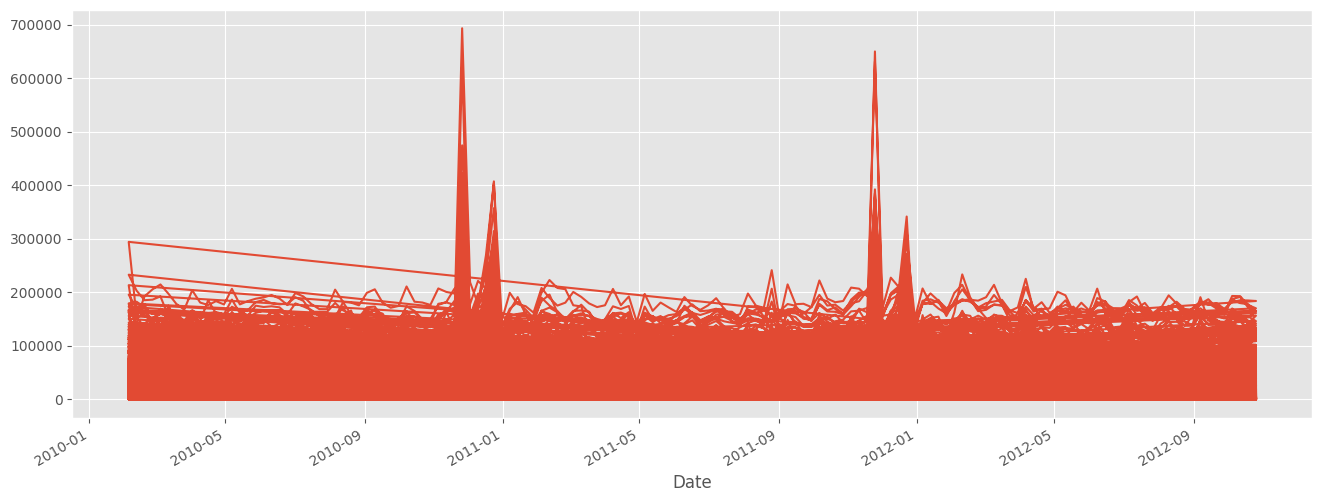

In [126]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

В этих данных много похожих/одинаковых значений. Итак, будем собирать их еженедельно.

In [127]:
df_numeric = df.select_dtypes(exclude=['object'])

In [128]:
df_week = df_numeric.resample('W').mean()

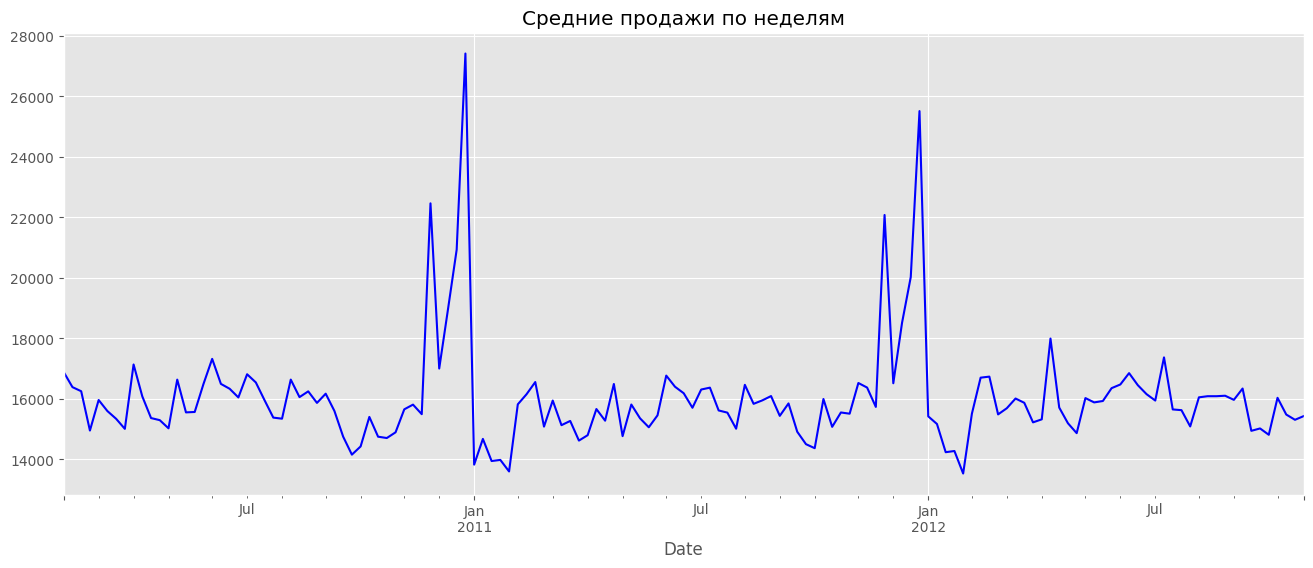

In [129]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot(color='b')
plt.title('Средние продажи по неделям')
plt.show()

Поскольку данные собираются еженедельно, четко видны средние продажи. Чтобы увидеть ежемесячную статистику, аналогично преобразуем данные в ежемесячные.

In [130]:
df_month = df_numeric.resample('MS').mean()

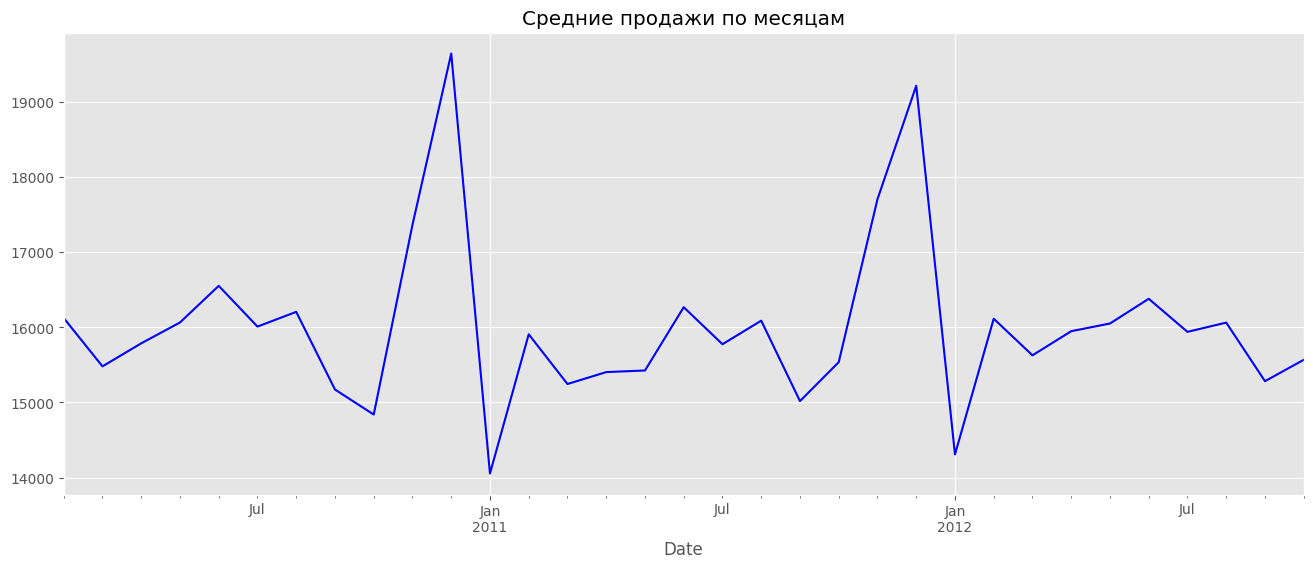

In [131]:
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot(color='b')
plt.title('Средние продажи по месяцам')
plt.show()

После переведения данных в режим ежемесячной выборки, становится понятно, что теряются некоторые закономерности в еженедельных данных. Итак, продолжим с еженедельными данными.

**Наблюдение за двухнедельным скользящим средним и стандартным отклонением**

Рассматриваемые данные нестационарны, попробуем найти более стационарную версию для них.

In [132]:
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

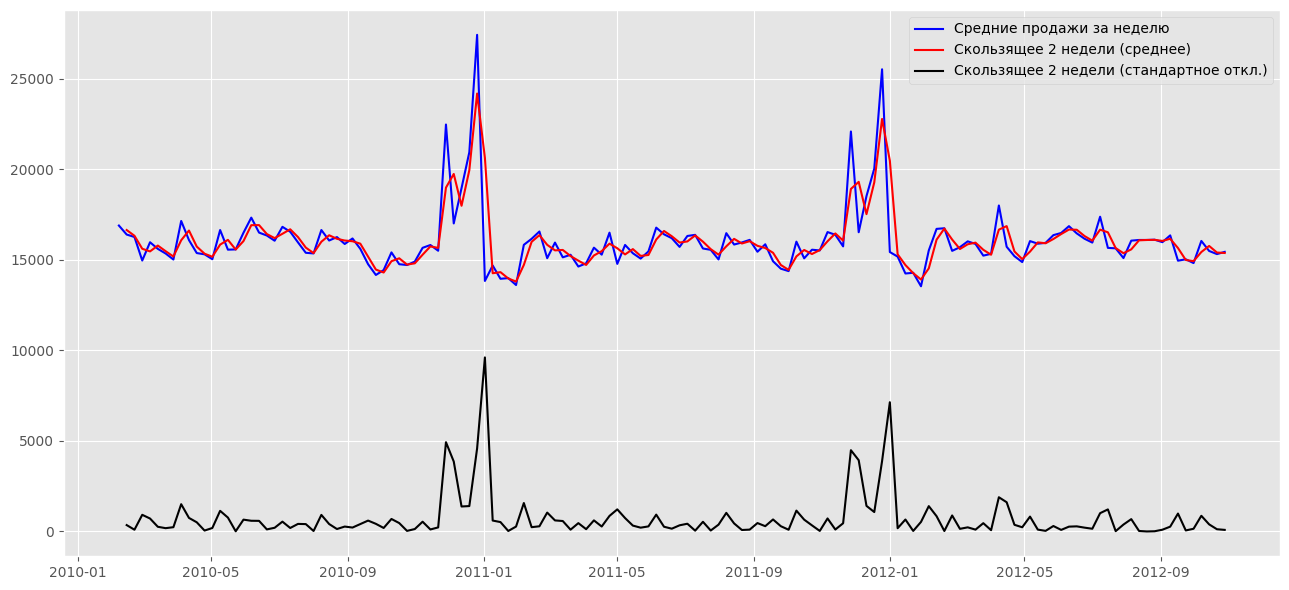

In [133]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue', label='Средние продажи за неделю')
ax.plot(roll_mean, color='red', label='Скользящее 2 недели (среднее)')
ax.plot(roll_std, color='black', label='Скользящее 2 недели (стандартное откл.)')
ax.legend()
fig.tight_layout()

Adfuller-тест, чтобы убедиться.

In [134]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737572,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

Из теста и наблюдений видно, что ряд не стационарен. Исправим это.

**Разделение на тренировочную/обучающую выборки данных о неделях**

Чтобы выполнять разбиение на подвыборки непрерывно, разбиваем их вручную, а не случайным образом.

In [135]:
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 21)
Test: (43, 21)


In [136]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]]

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

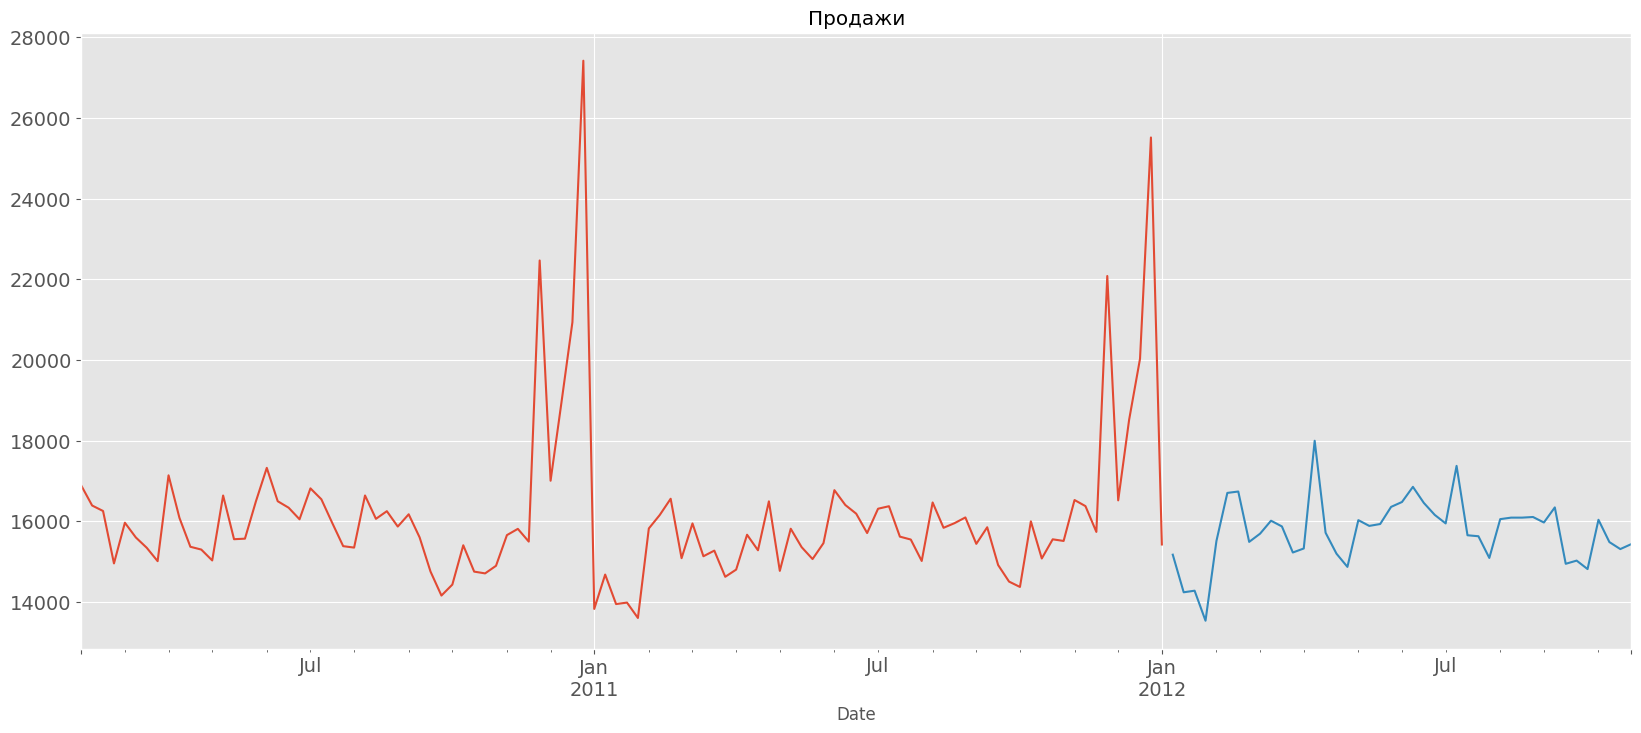

In [137]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Продажи', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Продажи', fontsize=14)
plt.show()

Синяя линия представляет данные о тестовых данных, желтая - тренировочные данные.

**Анализ еженедельных данных для учета сезонности**

In [138]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20)

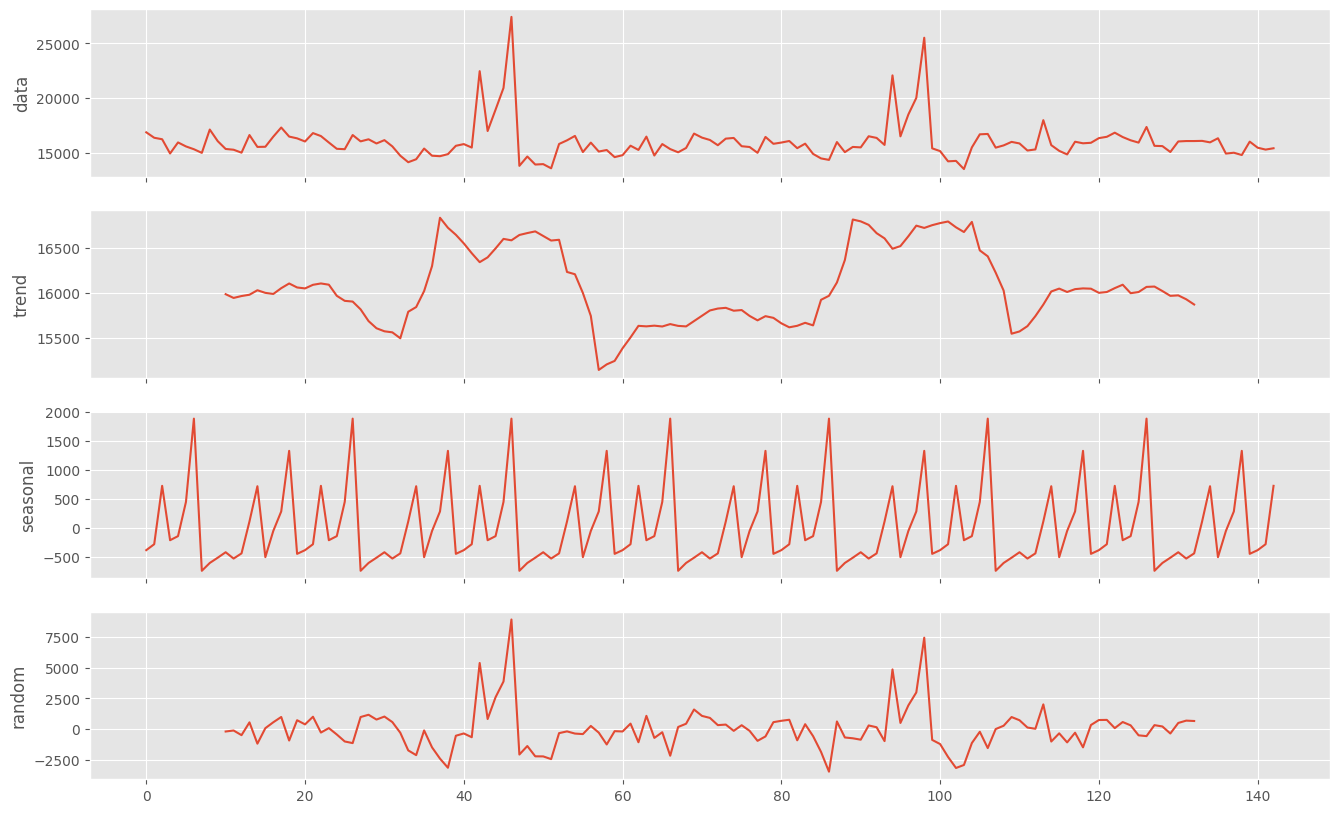

In [139]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

Из приведенных выше графиков видно, что каждые 20 шагов сезонность приближается к начальной точке. Это помогает настроить модель.

**Попытка сделать данные более стационарными**

Теперь попытаемся сделать данные более стационарными. Для этого попробуем создать модель с разностными и сдвинутыми данными.

1) Разница

In [140]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna()

In [141]:
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

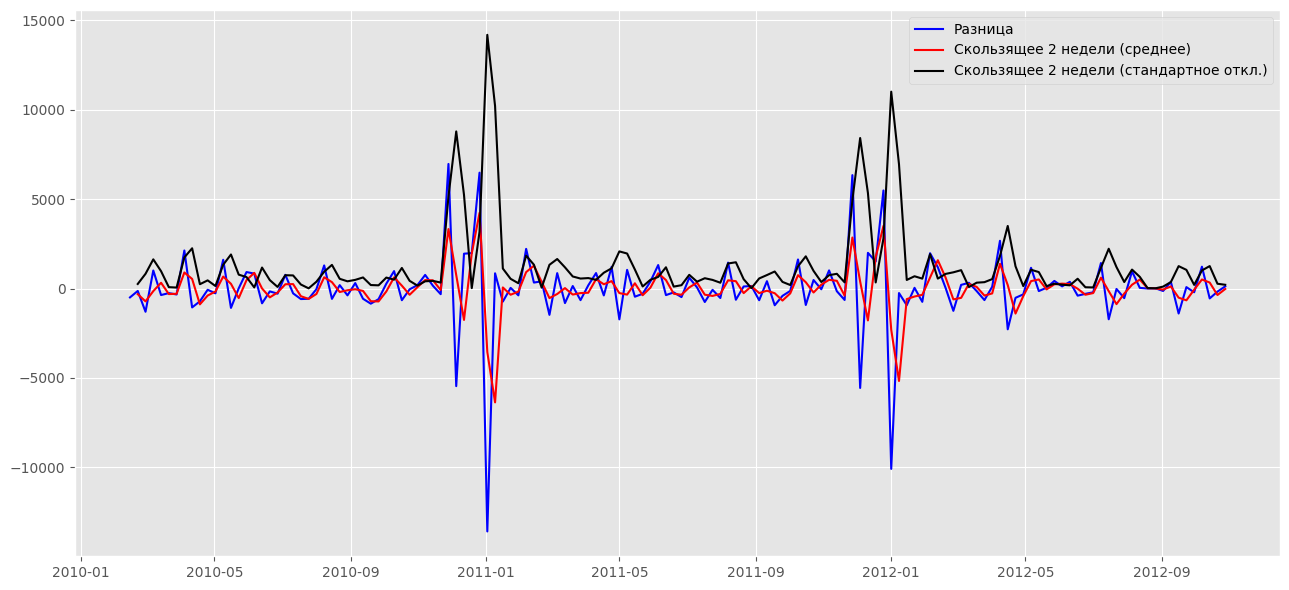

In [149]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Разница')
ax.plot(diff_roll_mean, color='red', label='Скользящее 2 недели (среднее)')
ax.plot(diff_roll_std, color='black', label='Скользящее 2 недели (стандартное откл.)')
ax.legend()
fig.tight_layout()

2) Сдвиг

In [144]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna()

In [145]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean()
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

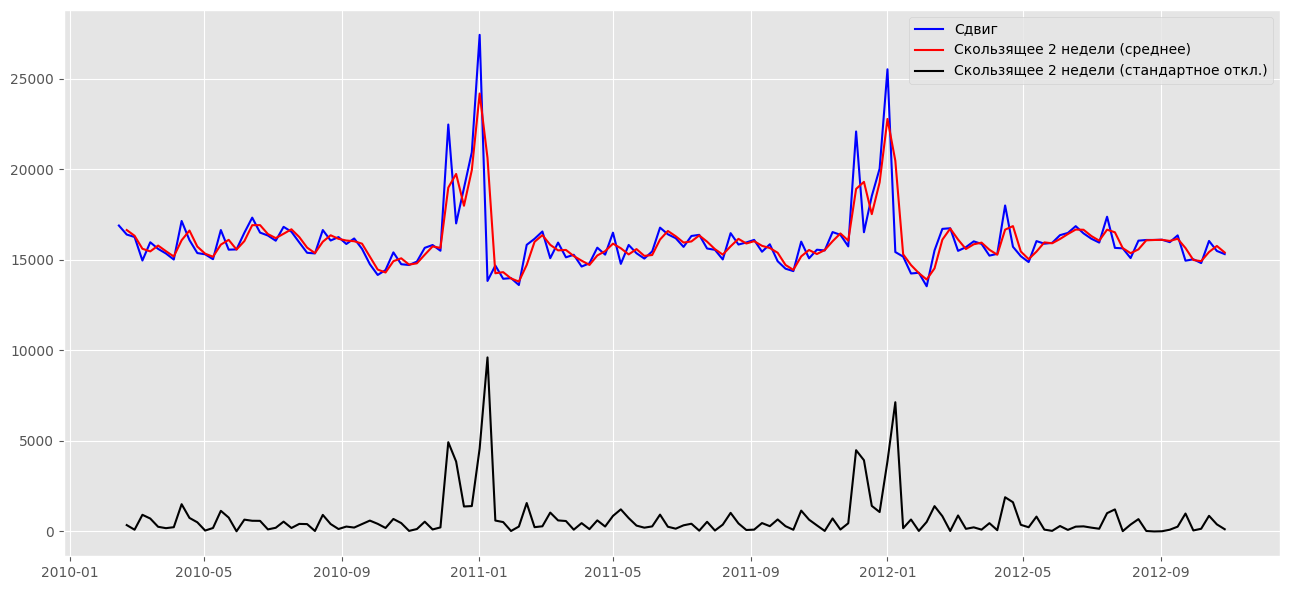

In [150]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Сдвиг')
ax.plot(lag_roll_mean, color='red', label='Скользящее 2 недели (среднее)')
ax.plot(lag_roll_std, color='black', label='Скользящее 2 недели (стандартное откл.)')
ax.legend()
fig.tight_layout()

3) Логарифмирование

In [147]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna()

In [148]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

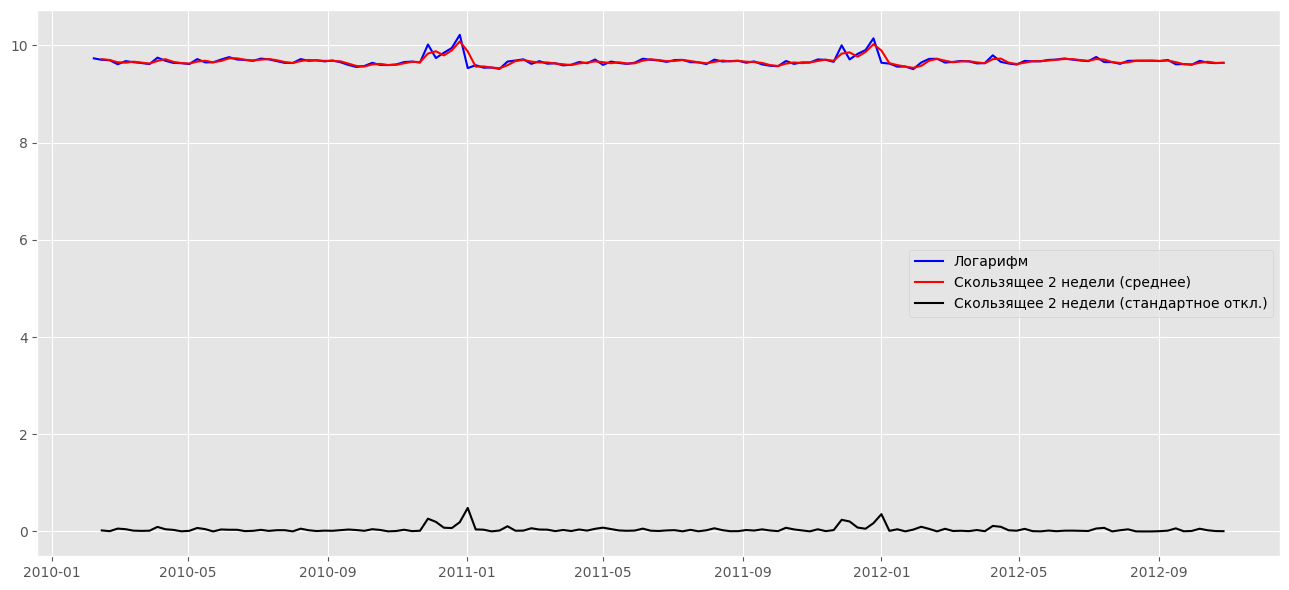

In [151]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Логарифм')
ax.plot(log_roll_mean, color='red', label='Скользящее 2 недели (среднее)')
ax.plot(log_roll_std, color='black', label='Скользящее 2 недели (стандартное откл.)')
ax.legend()
fig.tight_layout()

**Модель Auto-ARIMA**

Были попробованы данные без каких-либо изменений, затем со сдвигом, затем с логарифмической и разностной версией данных. Разностные данные дали наилучшие результаты. Итак, будем пользоваться разницей и использовать эти данные.

In [152]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [153]:
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=1.39 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=2.99 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.91 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=5.67 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

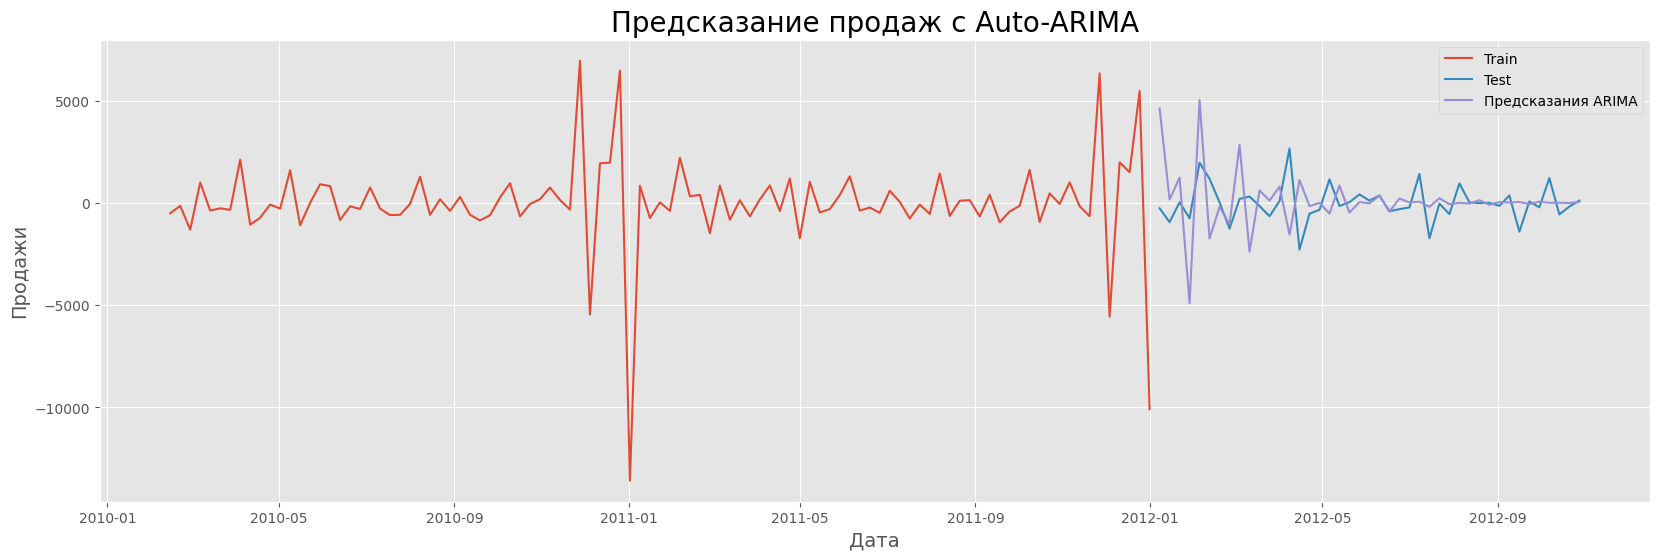

In [154]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Предсказание продаж с Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Предсказания ARIMA')
plt.legend(loc='best')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Продажи', fontsize=14)
plt.show()

Результаты не выглядят впечатляющими, поэтому попробуем другую модель.

**Модель Экспоненциального сглаживания**

Экспоненциальное сглаживание используется, когда данные имеют тренд, и это сглаживает тренд. Метод затухающего тренда добавляет параметр затухания, чтобы в будущем тренд сходился к постоянному значению.

Данные с разницей имеют несколько отрицательных и нулевых значений, поэтому используем аддитивные сезонные и трендовые значения вместо мультипликативных. Сезонные периоды выбраны из приведенных выше графиков. Для настройки модели с помощью итераций требуется слишком много времени, поэтому изменяя и пробуя модель для разных параметров, найдем наилучшие параметры и подгоним их под модель. Результат следующий.

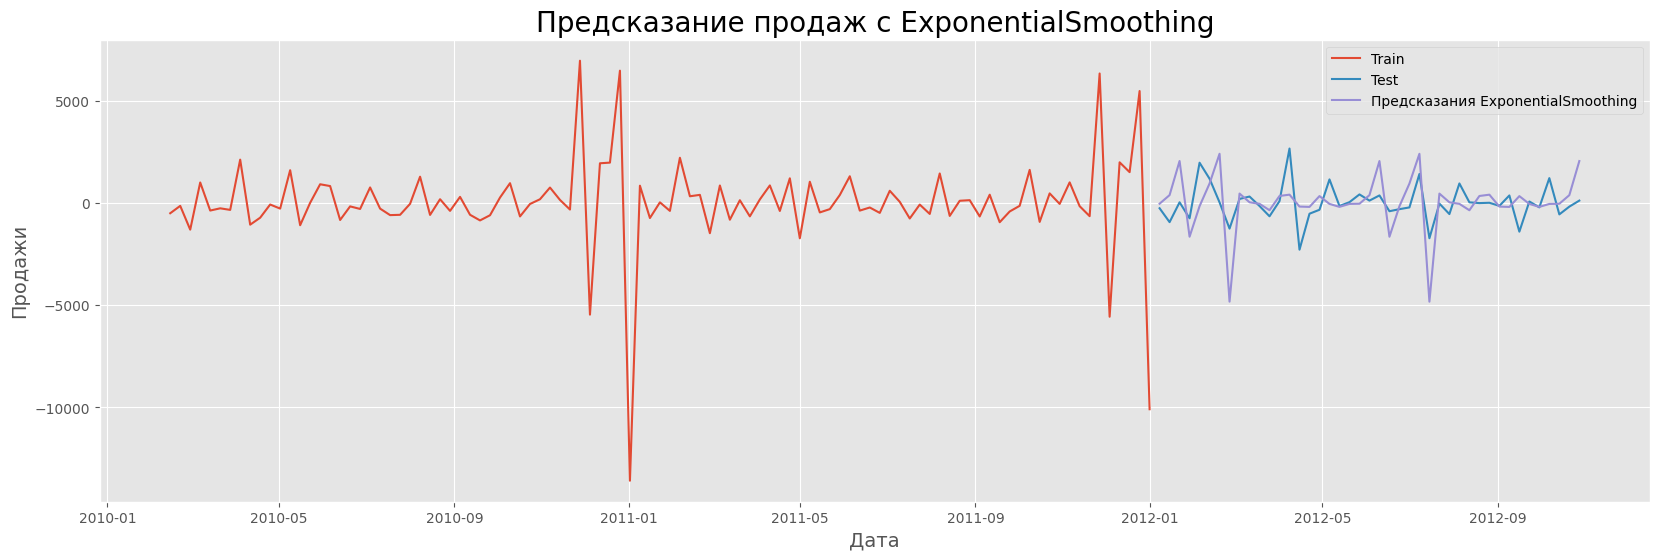

In [155]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit()
y_pred = model_holt_winters.forecast(len(test_data_diff))

plt.figure(figsize=(20,6))
plt.title('Предсказание продаж с ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Предсказания ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Продажи', fontsize=14)
plt.show()

In [156]:
wmae_test(test_data_diff, y_pred)

840.681060966696

В конце концов, наилучшие результаты были получены с помощью модели экспоненциального сглаживания.